# 極小場地定位Code

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

from csidataset import *
import data_loader
from data_loader import *
sys.path.append("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool")
import denoise
from model import *

In [2]:
base_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/micro/0303/80Mhz/csv"

In [3]:
reference_points = {
    f"{base_path}/reference_point{i}.xlsx": i for i in range(1, 37)
}

# 確認字典內容
print(reference_points)


{'/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/micro/0303/80Mhz/csv/reference_point1.xlsx': 1, '/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/micro/0303/80Mhz/csv/reference_point2.xlsx': 2, '/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/micro/0303/80Mhz/csv/reference_point3.xlsx': 3, '/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/micro/0303/80Mhz/csv/reference_point4.xlsx': 4, '/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/micro/0303/80Mhz/csv/reference_point5.xlsx': 5, '/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/micro/0303/80Mhz/csv/reference_point6.xlsx': 6, '/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/micro/0303/80Mhz/csv/reference_point7.xlsx': 7, '/med

In [4]:
def load_data(reference_points):
    data = []          
    rp_labels = []     

    for path, ref_id in reference_points.items():
        df = pd.read_excel(path)
        data.append(df.values)
        rp_labels.extend([ref_id] * len(df))  # 只保留 Reference Point ID

    data = pd.DataFrame(np.vstack(data))
    rp_labels = pd.Series(rp_labels, name="Reference Point ID")  # 轉為 Pandas Series

    return data, rp_labels


In [5]:
data, rp_labels = load_data(reference_points)


In [6]:

print(data.shape)       # 顯示數據
print(rp_labels.shape)  # 顯示 Reference Point ID


(7164, 470)
(7164,)


In [7]:
amp_data = np.array(data.iloc[:, :234])
phase_data = np.array(data.iloc[:, 234:-2])  

In [8]:
amp_d = denoise.preprocess_csi_for_fingerprint2(amp_data)
phase_d = denoise.preprocess_csi_for_fingerprint2(phase_data)

amp_phase_d = np.concatenate((amp_d, phase_d), axis=1)

In [9]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = encoder.fit_transform(np.array(rp_labels).reshape(-1, 1))

In [10]:
print(amp_d.shape)
print(phase_data.shape)
print(one_hot_labels.shape)

(7164, 234)
(7164, 234)
(7164, 36)


In [11]:
amp_train, amp_temp, y_train, y_temp = train_test_split(amp_phase_d, one_hot_labels, test_size=0.3, random_state=42)
amp_val, amp_test, y_val, y_test = train_test_split(amp_temp, y_temp, test_size=1/3, random_state=42)

In [12]:
amp_train.shape

(5014, 468)

In [13]:
batch_size = 32

train_dataset = CSIDataset(amp_train, y_train)
val_dataset = CSIDataset(amp_val, y_val)
test_dataset = CSIDataset(amp_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CNNClassifier(nn.Module):
    def __init__(self, num_classes=36):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten_dim = self._get_flatten_dim()
        #self.flatten_dim = 7424  # 48 -> 24 -> 12 after pooling

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def _get_flatten_dim(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 468)  # Simulate a batch of 1 input
            dummy_output = self._forward_features(dummy_input)
            return dummy_output.numel()  # Compute total number of features

    def _forward_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        return x


    def forward(self, x):
        # Ensure input is in the shape (batch_size, channels, length)
        if x.dim() == 2:
            x = x.unsqueeze(1)

        if x.shape[1] != 1:
            x = x.permute(0, 2, 1)  # (batch_size, 1, 48)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

# Initialize the model
model = CNNClassifier(num_classes=36).to(device)

# Print model summary
summary(model, input_size=(1,468))  # Input shape: (channels, length)

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 468]             256
       BatchNorm1d-2              [-1, 64, 468]             128
         MaxPool1d-3              [-1, 64, 234]               0
            Conv1d-4             [-1, 128, 234]          24,704
       BatchNorm1d-5             [-1, 128, 234]             256
         MaxPool1d-6             [-1, 128, 117]               0
            Linear-7                  [-1, 128]       1,917,056
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
          Dropout-10                   [-1, 64]               0
           Linear-11                   [-1, 36]           2,340
Total params: 1,952,996
Trainable params: 1,952,996
Non-trainable params: 0
----------------------------------------------------------------
Input s

In [27]:
import torch.nn as nn
import torch.optim as optim

# 損失函數
criterion = nn.CrossEntropyLoss()

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 學習率調整器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

In [29]:
import torch
import matplotlib.pyplot as plt
import time

# 儲存最佳模型
best_val_loss = float('inf')
best_model_path = "./models_save/best_model(mirco)0303-amp+phase.pth"

# 訓練參數
epochs = 200

# early stop
patience = 20
counter = 0  

#觀察收斂速度
target_acc = 98  # 設定目標準確率
best_epoch = None

# 訓練過程中的 loss 和 accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    start_time = time.perf_counter()  # 記錄開始時間
    
    # ---- 訓練階段 ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # CrossEntropyLoss 需要 class index
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    # ----驗證階段----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    epoch_time = time.perf_counter() - start_time

    # 記錄每個 epoch 的 loss 和 accuracy
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # 計算時間
    #epoch_time = time.time() - start_time  # 計算這個 epoch 所花的時間

    # 輸出當前 epoch 的結果
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Time: {epoch_time:.2f} sec")

    # ---- 儲存最佳模型 ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    # if counter >= patience:
    #     print(f"Early stop at epoch {epoch+1}")
    #     break
    if val_acc >= target_acc and best_epoch is None:
        best_epoch = epoch + 1
    if best_epoch:
        print(f"🎯 達到 {target_acc}% 準確率的 Epoch: {best_epoch}")
print("訓練完成！")


Epoch [1/200] | Train Loss: 0.2581 | Train Acc: 92.10% | Val Loss: 0.5686 | Val Acc: 92.25% | Time: 0.37 sec
✅ 儲存最佳模型 (Val Loss: 0.5686) 至 ./models_save/best_model(mirco)0303-amp+phase.pth
Epoch [2/200] | Train Loss: 0.2767 | Train Acc: 90.89% | Val Loss: 0.5401 | Val Acc: 92.53% | Time: 0.36 sec
✅ 儲存最佳模型 (Val Loss: 0.5401) 至 ./models_save/best_model(mirco)0303-amp+phase.pth
Epoch [3/200] | Train Loss: 0.2701 | Train Acc: 91.54% | Val Loss: 0.5933 | Val Acc: 92.88% | Time: 0.36 sec
Epoch [4/200] | Train Loss: 0.2519 | Train Acc: 92.12% | Val Loss: 0.5280 | Val Acc: 92.25% | Time: 0.35 sec
✅ 儲存最佳模型 (Val Loss: 0.5280) 至 ./models_save/best_model(mirco)0303-amp+phase.pth
Epoch [5/200] | Train Loss: 0.2537 | Train Acc: 91.88% | Val Loss: 0.5584 | Val Acc: 91.91% | Time: 0.35 sec
Epoch [6/200] | Train Loss: 0.2485 | Train Acc: 92.16% | Val Loss: 0.5290 | Val Acc: 92.18% | Time: 0.35 sec
Epoch [7/200] | Train Loss: 0.2378 | Train Acc: 92.48% | Val Loss: 0.5450 | Val Acc: 92.25% | Time: 0.35 s

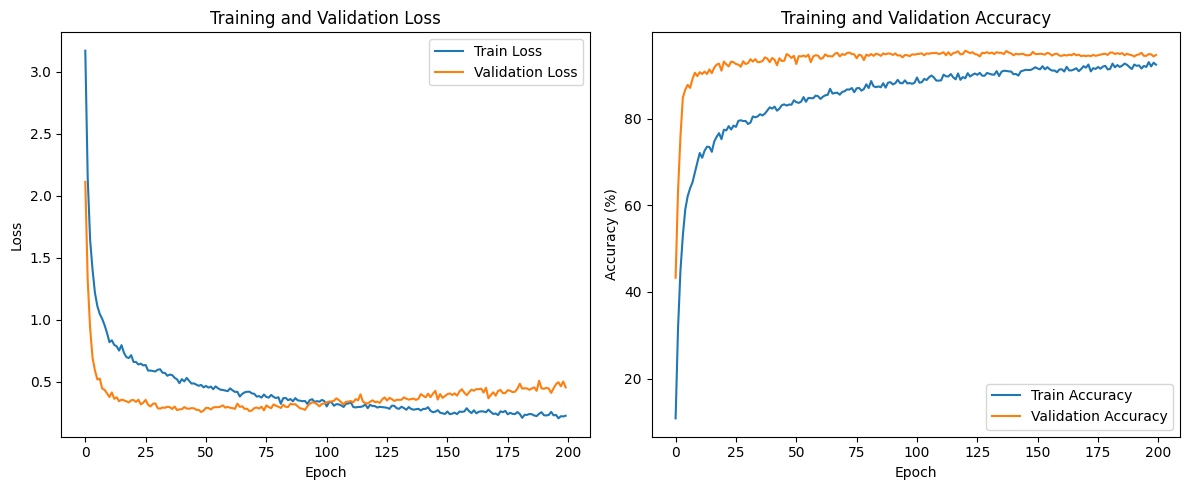

In [43]:
plt.figure(figsize=(12, 5))

# ---- loss ----
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ---- accuracy ----
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

📊 測試損失: 0.1570, 測試準確率: 95.12%
⏳ 平均每筆資料推論時間: 0.0137 毫秒


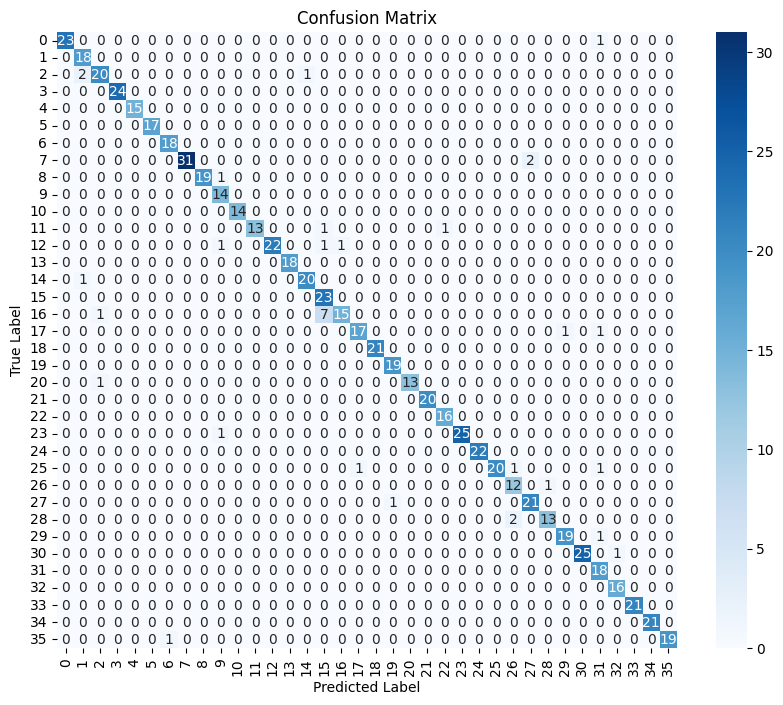

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import time

# 載入最佳模型
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/models_save/best_model(mirco)0303-amp+phase.pth"))
model.eval()

# 測試模型
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
total_time = 0  # 用來累積測試時間

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 記錄開始時間
        torch.cuda.synchronize()  # 確保 GPU 所有計算同步
        start_time = time.perf_counter()

        outputs = model(inputs)  # 進行推論

        torch.cuda.synchronize()  # 確保 GPU 完成推論
        end_time = time.perf_counter()
        
        batch_time = end_time - start_time  # 計算批次時間
        total_time += batch_time  # 累積總時間

        # 計算 Loss
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        test_loss += loss.item() * inputs.size(0)

        # 預測結果
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        # 儲存真實標籤與預測標籤
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 計算最終測試損失與準確率
test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

# 計算平均每筆資料的推論時間
num_samples = len(test_loader.dataset)
avg_inference_time = total_time / num_samples

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")
print(f"⏳ 平均每筆資料推論時間: {avg_inference_time * 1000:.4f} 毫秒")


# 計算 Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# 畫出 Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(36), yticklabels=range(36))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
